In [14]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.ticker import AutoMinorLocator
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation, PillowWriter
import warnings
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u


In [2]:
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/keckimage.fits
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/adi_oct172021.fits
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/asdicomb_indiv.fits
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect2/files/leggett.txt

#turn off warnings for blank headers in fits
warnings.filterwarnings('ignore')


--2023-11-13 19:06:03--  https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/keckimage.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1074240 (1.0M) [application/octet-stream]
Saving to: ‘keckimage.fits’

keckimage.fits      100%[===================>]   1.02M  --.-KB/s    in 0.07s   

2023-11-13 19:06:03 (15.0 MB/s) - ‘keckimage.fits’ saved [1074240/1074240]

--2023-11-13 19:06:03--  https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/adi_oct172021.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

In [3]:
#open file
with fits.open('keckimage.fits') as hdul:
    image_data = hdul[0].data
    header = hdul[0].header


    altitude = header['ALTITUDE']
    azimuth = header['AZIMUTH']

    #print altitude and azimuth
    print(f'Altitude: {altitude}')
    print(f'Azimuth: {azimuth}')

    #numpy call for dim
    numpy_dimension = image_data.shape
    print(f'Numpy Dimension Call/Image Size : {numpy_dimension}')

    #same array but read in shape of 0
    astropy_dimension = hdul[0].shape
    print(f'Astropy Dimension Call/Image Size: {astropy_dimension}')


Altitude: 65.39478
Azimuth: 3.43391
Numpy Dimension Call/Image Size : (512, 512)
Astropy Dimension Call/Image Size: (512, 512)


In [4]:
#open fits file
with fits.open('adi_oct172021.fits') as hdul:

    #found apeture radius: R_AP3-1 -> R_AP2
    aperture_radius = hdul[1].header.get('R_AP2')
    print(f'Aperture Radius for the third slice: {aperture_radius}')

    #set given pixel values
    y_px = 79
    x_px = 82

    pixel_value = hdul[1].data[9, y_px, x_px]
    print(f'Pixel Value at 10th slice [x={x_px}, y={y_px}]: {pixel_value}')

    flux_density_units = hdul[1].header.get('FLUXUNIT')
    print(f'Flux Density Units: {flux_density_units}')

Aperture Radius for the third slice: 1.00023594697
Pixel Value at 10th slice [x=82, y=79]: 0.02506706491112709
Flux Density Units: mJy


In [5]:
#open fits file
with fits.open('adi_oct172021.fits') as hdul:
    #calculate median along all wavelength/slices
    median_image = np.median(hdul[1].data, axis=0)

    #new primary hdu for median image
    hdu_median = fits.PrimaryHDU(data=median_image, header=hdul[1].header)

    # Write the median image to a new FITS file
    hdu_median.writeto('median_adi_oct172021.fits')
    print('Saved Sucesfully!')


Saved Sucesfully!


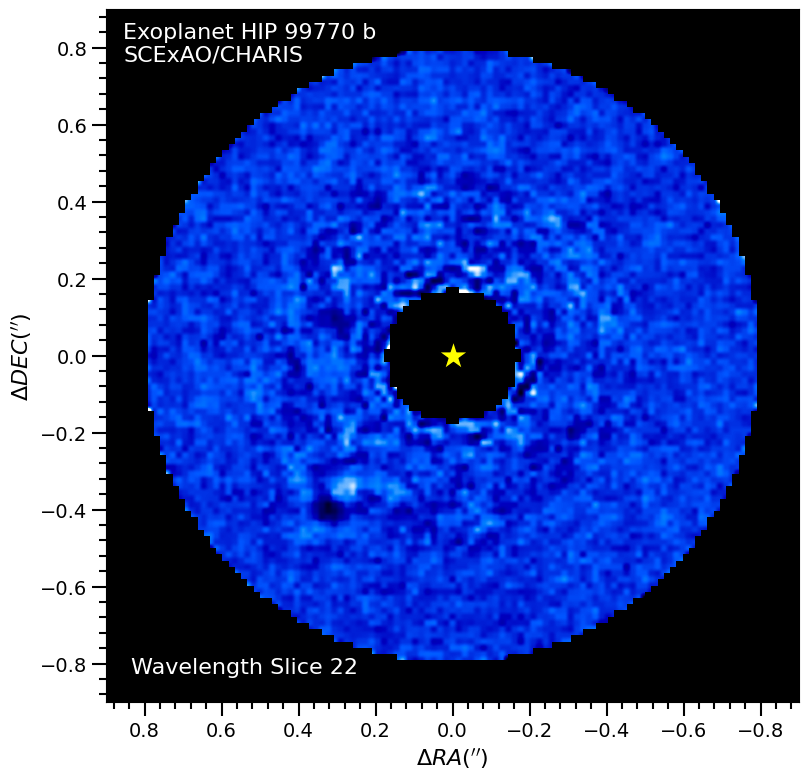

In [6]:
#wavelength slice params
vertical_offset = .05  #fraction of height from bottom
horizontal_offset = .2  #fraction from left




import matplotlib as mpl
R, G, B, A = mpl.cm.get_cmap('gist_heat')(np.linspace(0.0, 1.0, 256)).T
color_vals = np.array([B, G, R, A]).T
cmap1 = mpl.colors.ListedColormap(color_vals)  # colormap for CHARIS image
cmap1.set_bad('k')


data_cube = (fits.open('asdicomb_indiv.fits'))[0].data

n_lambda = (data_cube.shape)[0]

# general formatting

rmax = 0.9  # in units of arc-seconds
pixelscale = 0.01615
extrange = [rmax, -1 * rmax, -1 * rmax, rmax]

fullext_image = pixelscale * (data_cube.shape)[1] / 2.0

cmapval = 'plasma'
cmapval = cmap1

fig, axes = plt.subplots(figsize=(9, 9))
immovie = []

axes.set_xlim(rmax, -1 * rmax)
axes.set_ylim(-1 * rmax, rmax)
axes.tick_params(which='both', direction='out', labelsize=14)
axes.tick_params(which='major', length=10, width=1.5)
axes.tick_params(which='minor', length=5, width=1.5)
axes.xaxis.set_minor_locator(AutoMinorLocator(5))
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.set_xlabel('$\Delta RA(^{\prime\prime})$', fontsize=16)
axes.set_ylabel('$\Delta DEC(^{\prime\prime})$', fontsize=16)

axes.text(0.95*rmax,0.85*rmax,'Exoplanet HIP 99770 b\nSCExAO/CHARIS',fontsize=16,color='w')
axes.scatter(0,0,marker='*',c='yellow',edgecolor='black',s=500)

for i in range(n_lambda):
    climsp = np.nanpercentile(data_cube[i, :, :], [0, 99.9])
    clims = [-1.5 * climsp[1], climsp[1]]
    interpval = 'hanning'

    im = axes.imshow(data_cube[i, :, :], animated=True, clim=clims, origin='lower',
                     extent=[fullext_image, -1 * fullext_image, -1 * fullext_image, fullext_image],
                     interpolation=interpval, cmap=cmapval)
    #text to add for each wavelegnth slcice here, passed params, changed zorder
    counter = axes.text(horizontal_offset, vertical_offset, f'Wavelength Slice {i+1}',
                    fontsize=16, color='white', ha='center', va='center',
                    transform=axes.transAxes, animated=True, zorder=3)

    #include counter in immovie
    immovie.append([im, counter])

ani = ArtistAnimation(fig, immovie, interval=50, blit=True, repeat_delay=500)

#save as gif
ani.save('exoplanet_hip99770b.gif', writer='pillow', fps=10)

#save as mp4
ani.save('exoplanet_hip99770b.mp4', writer='ffmpeg', fps=10)



In [7]:
# Wavelength slice params
vertical_offset = 0.05  # Fraction of height from bottom
horizontal_offset = 0.2  # Fraction from left

def create_colormap(cmap_name):
    R, G, B, A = mpl.cm.get_cmap(cmap_name)(np.linspace(0.0, 1.0, 256)).T
    color_vals = np.array([B, G, R, A]).T
    cmap = mpl.colors.ListedColormap(color_vals)  # colormap for image
    cmap.set_bad('k')
    return cmap

def setup_plot(rmax, pixelscale, data_shape):
    fig, axes = plt.subplots(figsize=(9, 9))
    fullext_image = pixelscale * data_shape[1] / 2.0

    axes.set_xlim(rmax, -1 * rmax)
    axes.set_ylim(-1 * rmax, rmax)
    axes.tick_params(which='both', direction='out', labelsize=14)
    axes.tick_params(which='major', length=10, width=1.5)
    axes.tick_params(which='minor', length=5, width=1.5)
    axes.xaxis.set_minor_locator(AutoMinorLocator(5))
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    axes.set_xlabel('$\Delta RA(^{\prime\prime})$', fontsize=16)
    axes.set_ylabel('$\Delta DEC(^{\prime\prime})$', fontsize=16)
    axes.text(0.95*rmax, 0.85*rmax, 'Exoplanet HIP 99770 b\nSCExAO/CHARIS', fontsize=16, color='w')
    axes.scatter(0, 0, marker='*', c='yellow', edgecolor='black', s=500)

    return fig, axes, fullext_image

def create_animation(fig, axes, data_cube, cmapval, rmax, fullext_image, vertical_offset, horizontal_offset):
    immovie = []
    n_lambda = data_cube.shape[0]  # Number of wavelength slices

    for i in range(n_lambda):
        # Calculate the color scale limits based on the data
        climsp = np.nanpercentile(data_cube[i, :, :], [0, 99.9])
        clims = [-1.5 * climsp[1], climsp[1]]
        interpval = 'hanning'

        # Display the data
        im = axes.imshow(data_cube[i, :, :], animated=True, clim=clims, origin='lower',
                         extent=[-fullext_image, fullext_image, -fullext_image, fullext_image],
                         interpolation=interpval, cmap=cmapval)

        # Add the text for each frame, using the offsets and ensuring it's on top of the image with zorder
        counter = axes.text(horizontal_offset, vertical_offset, f'Wavelength Slice {i+1}',
                            fontsize=16, color='white', ha='center', va='center',
                            transform=axes.transAxes, animated=True, zorder=3)

        # Append both the image and the text to the animation frames
        immovie.append([im, counter])

    # Create the animation object
    ani = ArtistAnimation(fig, immovie, interval=50, blit=True, repeat_delay=500)

    return ani


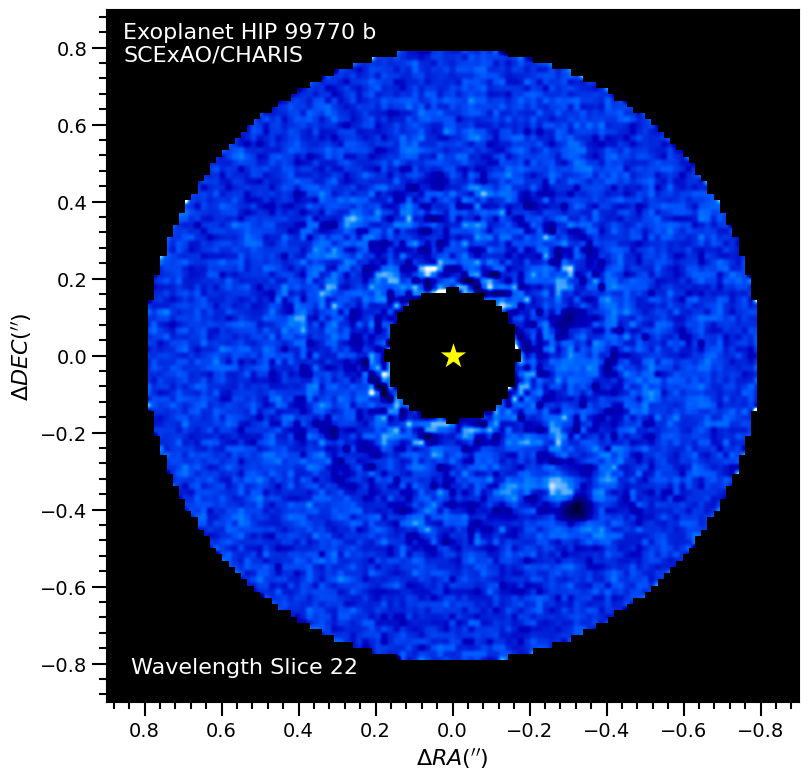

In [8]:
cmapval = create_colormap('gist_heat')
fig, axes, fullext_image = setup_plot(rmax, pixelscale, data_cube.shape)
ani = create_animation(fig, axes, data_cube, cmapval, rmax, fullext_image, vertical_offset, horizontal_offset)
ani.save('exoplanet_hip99770b.gif', writer='pillow', fps=10)
ani.save('exoplanet_hip99770b.mp4', writer='ffmpeg', fps=10)

##Problem 6:
### Appears to be MRT
The table appear to be in mrt format. I've specficed the format type in the code below. There are also a few give aways:
1. Byte-by-Byte Description
2. Fixed column widths
3. No delimeters
4. Line of '---'


In [32]:
################ CURRENTLY INCORRECT NEED TO FIX #######################


table = ascii.read('leggett.txt',format='mrt')
print(table.columns)

#to get distance we can rearrange
# M-m = -5 log(d/10)
#where D = 10*10^(-M-m/5)


#distance in parsecs without rounding
table['Distance'] = 10 * 10 ** (-table['M-m'] / 5)

#H band mag without rounding yet
table['abs Hmag'] = table['Hmag'] - table['M-m']

#relevent columns for new table
updated_table = table['Name', 'Distance', 'Hmag', 'abs Hmag']

#formats for saving, both 2 decimals
formats = {'Distance': '%.2f', 'abs Hmag': '%.2f'}

#write to .tex
ascii.write(updated_table, 'newleggett.tex', format='latex', formats=formats, overwrite=True)

<TableColumns names=('Name','RAh','DEded','SpType','M-m','JMag','Ymag','Jmag','Hmag','Kmag','Lmag','Mmag','3.6mag','4.5mag','5.9mag','8.0mag','e_SpType','e_M-m','e_Ymag','e_Jmag','e_Kmag','e_Lmag','e_Mmag','e_3.6mag','e_4.5mag','e_5.9mag','e_8.0mag','DRef','SpRef','PiRef','YRef','JHKRef','LMRef','IRef','BinRef')>


In [27]:
# 'read it back in to make sure its all good'
ascii.read('newleggett.tex')


Name,Distance,Hmag,abs Hmag
str17,float64,str14,float64
--,--,$\mathrm{mag}$,--
SDSS 0000+2554,--,14.74,--
SDSS 0001+1535,--,14.4,--
SDSS 0002+2454,--,16.09,--
LHS 102BC,-0.1,12.14,12.04
LHS 102A,-0.1,8.02,7.92
SDSS 0016-0043,--,15.34,--
BRI 0021-0214,0.37,11.1,11.47
2MASS 0028+1501,--,15.48,--


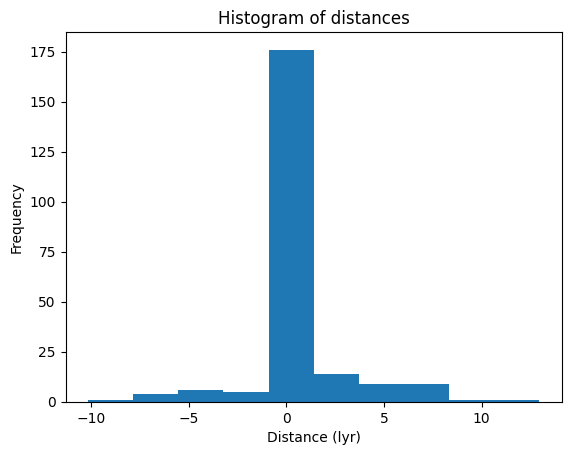

In [29]:
#ascii read file
data = ascii.read('newleggett.tex')


#distance column, assign units of pc
distances_pc = data['Distance'] * u.pc

#convert to lyr
distances_lyr = distances_pc.to(u.lyr)

#plt histogram
#ask him what is relative number?
plt.hist(distances_lyr.value, bins=10)
plt.xlabel("Distance (lyr)")
plt.ylabel("Frequency")
plt.title("Histogram of distances")
plt.show()